# MLB's Biggest All-Star Injustices

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Print accuracy of pandas crosstab
def crosstabAccuracy(ct):
    try:
        acc = (ct[0][0]+ct[1][1]) / (ct[0][0]+ct[1][1]+ct[0][1]+ct[1][0])
    except:
        acc = (ct[0][0]) / (ct[0][0]+ct[1][0])
    return(100*round(acc,3))

In [3]:
# Print classification report with specified threshold
def thresholdReport(continuous_predictions, actual_results, threshold):
    updated_preds = np.array([1 if pred > threshold else 0 for pred in continuous_predictions])
    print(classification_report(y_pred=updated_preds, y_true=actual_results))
    print(pd.crosstab(updated_preds, actual_results))

In [4]:
# Read data
fh = pd.read_csv('.\\data\\firsthalf.csv')

# Change 'position' to dummy variables
position_dummies = pd.get_dummies(fh.position)
fh = fh.drop('position', axis=1)
fh = pd.concat([fh, position_dummies], axis=1)

In [5]:
# Initial df metrics
print(fh.shape)
print(fh.made_asg.value_counts(normalize=True))
print(fh.columns)

(6745, 66)
0    0.814233
1    0.185767
Name: made_asg, dtype: float64
Index(['player', 'AVG', 'BABIP', 'BB%', 'BsR', 'Def', 'G', 'HR', 'ISO', 'K%',
       'OBP', 'Off', 'PA', 'R', 'RBI', 'SB', 'SLG', 'WAR', 'team', 'wOBA',
       'wRC+', 'year', 'league', 'league_year_ID', 'player_year_ID',
       'made_asg', 'num_games', 'playerID', 'started_asg', 'W-L%', 'popular',
       'NYY', 'BOS', 'CHC', 'LAD', 'team_year_id', 'won_WS_PY', 'lost_WS_PY',
       'played_WS_PY', 'DOB', 'years_old_SOS', 'rank_WAR', 'rank_wRC',
       'rank_OBP', 'rank_SLG', 'rank_HR', 'rank_AVG', 'rank_Off', 'rank_Def',
       'rank_SB', 'team_rank_WAR', 'team_rank_wRC', 'team_rank_OBP',
       'team_rank_SLG', 'team_rank_HR', 'team_rank_AVG', 'team_rank_Off',
       'team_rank_Def', 'team_rank_SB', '1B', '2B', '3B', 'C', 'DH', 'OF',
       'SS'],
      dtype='object')


In [6]:
# Set features
modelcols = [
    'AVG',
    'Def',
    'HR',
    'K%',
    'SB',
    'WAR',
    'popular',
    'won_WS_PY',
    'lost_WS_PY',
    '1B',
    '2B',
    '3B',
    'C',
    'DH',
    'OF',
    'SS'
]

Y = fh.made_asg
X = fh.loc[:,modelcols]

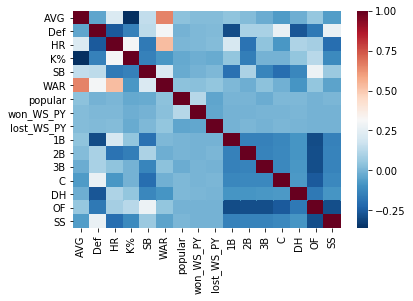

In [7]:
# Correlation matrix
sns.heatmap(X.corr(), cmap='RdBu_r')

In [8]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.20, 
                                                stratify=Y, random_state=1000)

### Logistic Regression (unscaled)

In [9]:
# Train logistic regression model
logR = LogisticRegression(penalty='l1')
logR.fit(Xtrain, Ytrain)
pd.crosstab(logR.predict(Xtrain), Ytrain)

made_asg,0,1
row_0,,
0,4218,433
1,176,569


In [10]:
# Test logistic regression model
logR_preds_binary = logR.predict(Xtest)
logR_preds_continuous = logR.predict_proba(Xtest)[:,1]
logR_ct = pd.crosstab(logR_preds_binary, Ytest)
print('Accuracy:',crosstabAccuracy(logR_ct))
print('AUC: {:.1f}'.format(100*roc_auc_score(y_score=logR_preds_continuous, y_true=Ytest)))
logR_ct

Accuracy: 89.0
AUC: 92.5


made_asg,0,1
row_0,,
0,1044,95
1,54,156


In [11]:
# Classification report @ 0.40 threshold
thresholdReport(continuous_predictions=logR_preds_continuous,
                actual_results=Ytest, 
                threshold=0.40)

             precision    recall  f1-score   support

          0       0.93      0.93      0.93      1098
          1       0.70      0.70      0.70       251

avg / total       0.89      0.89      0.89      1349

made_asg     0    1
row_0              
0         1023   75
1           75  176


In [12]:
# Feature coefficients
print(len(X.columns), 'features:')
for num, feature in enumerate(Xtrain.columns):
    print(logR.coef_[0][num], feature)

16 features:
12.379747894756527 AVG
-0.08465519851976787 Def
0.13280894704336563 HR
-0.08212782124728421 K%
0.03243155022366087 SB
1.1514895480457437 WAR
0.3034187139195672 popular
0.994338258269651 won_WS_PY
1.0377194586969876 lost_WS_PY
-1.1061999746345663 1B
0.0 2B
-0.2507775754295886 3B
1.1517490471387446 C
-1.16989673207255 DH
-0.8091043195673008 OF
0.5604062178846984 SS


### Lasso / Ridge / Elastic Net

In [13]:
# Scale all features for lasso, ridge, EN
scaler = StandardScaler()
Xtrainscaled = pd.DataFrame(scaler.fit_transform(Xtrain))
Xtrainscaled.columns = modelcols
Xtestscaled = pd.DataFrame(scaler.transform(Xtest))
Xtestscaled.columns = modelcols

In [14]:
# Binary columns back to 0-1
binaries = ['popular', 'NYY', 'BOS', 'CHC', 'LAD', 'won_WS_PY',
            'lost_WS_PY', 'played_WS_PY', '1B', '2B', '3B', 'C',
            'DH', 'OF', 'SS']
for col in binaries:
    try:
        Xtrainscaled[col] = Xtrainscaled[col].apply(lambda x: 1 if x>0 else 0)
        Xtestscaled[col] = Xtestscaled[col].apply(lambda x: 1 if x>0 else 0)
    except:
        pass

In [15]:
# Conduct Lasso, Ridge, EN for different levels of alpha (never outperforms logistic)
print('AUCs:\n\n')
for i in np.arange(0.01, 0.50, 0.02):
    alpha = i
    print('Alpha = {:.2f}'.format(alpha))
    
    lasso_model = SGDClassifier(penalty='l1', alpha=alpha, max_iter=100, loss='modified_huber')
    lasso_model.fit(Xtrainscaled, Ytrain)
    ridge_model = SGDClassifier(penalty='l2', alpha=alpha, max_iter=100, loss='modified_huber')
    ridge_model.fit(Xtrainscaled, Ytrain)
    elastic_model = SGDClassifier(penalty='l1', alpha=alpha, l1_ratio=0.50, max_iter=100, loss='modified_huber')
    elastic_model.fit(Xtrainscaled, Ytrain)

    lasso_model_preds = lasso_model.predict_proba(Xtestscaled)[:,1]
    print('Lasso: {:.1f}'.format(100*roc_auc_score(y_score=lasso_model_preds, y_true=Ytest)))

    ridge_model_preds = ridge_model.predict_proba(Xtestscaled)[:,1]
    print('Ridge: {:.1f}'.format(100*roc_auc_score(y_score=ridge_model_preds, y_true=Ytest)))    

    elastic_model_preds = elastic_model.predict_proba(Xtestscaled)[:,1]
    print('Elastic: {:.1f}'.format(100*roc_auc_score(y_score=elastic_model_preds, y_true=Ytest)))
    
    print('------------')

AUCs:


Alpha = 0.01
Lasso: 91.3
Ridge: 92.2
Elastic: 91.6
------------
Alpha = 0.03
Lasso: 90.4
Ridge: 92.0
Elastic: 90.6
------------
Alpha = 0.05
Lasso: 90.2
Ridge: 91.9
Elastic: 90.2
------------
Alpha = 0.07
Lasso: 90.3
Ridge: 91.9
Elastic: 90.1
------------
Alpha = 0.09
Lasso: 90.1
Ridge: 91.8
Elastic: 90.3
------------
Alpha = 0.11
Lasso: 90.1
Ridge: 91.7
Elastic: 90.1
------------
Alpha = 0.13
Lasso: 90.1
Ridge: 91.6
Elastic: 90.1
------------
Alpha = 0.15
Lasso: 90.1
Ridge: 91.5
Elastic: 90.1
------------
Alpha = 0.17
Lasso: 90.1
Ridge: 91.5
Elastic: 90.1
------------
Alpha = 0.19
Lasso: 90.0
Ridge: 91.4
Elastic: 89.2
------------
Alpha = 0.21
Lasso: 89.9
Ridge: 91.4
Elastic: 90.0
------------
Alpha = 0.23
Lasso: 89.9
Ridge: 91.3
Elastic: 89.9
------------
Alpha = 0.25
Lasso: 89.1
Ridge: 91.3
Elastic: 88.7
------------
Alpha = 0.27
Lasso: 89.0
Ridge: 91.3
Elastic: 89.7
------------
Alpha = 0.29
Lasso: 89.5
Ridge: 91.2
Elastic: 89.5
------------
Alpha = 0.31
Lasso: 88.7
Ridge: 

### Random Forest

In [16]:
# Grid search for random forest
params = {
    'max_depth':[5,6,7,8],
    'max_features':[3,5,10,None],
    'min_samples_leaf':[1,3,7,11],
    'n_estimators':[301]   
}

rf_for_gs = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator=rf_for_gs, param_grid=params, cv=7, n_jobs=4)
grid_search_rf.fit(Xtrain, Ytrain)

GridSearchCV(cv=7, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [5, 6, 7, 8], 'max_features': [3, 5, 10, None], 'min_samples_leaf': [1, 3, 7, 11], 'n_estimators': [301]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
# Best random forest parameters
grid_search_rf.best_params_

{'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 3, 'n_estimators': 301}

In [18]:
# Train model
rf = RandomForestClassifier(max_depth=8, max_features=5, min_samples_leaf=3, 
                            n_estimators=1001, oob_score=True)
rf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1001, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [19]:
# Training results
pd.crosstab(rf.predict(Xtrain), Ytrain)

made_asg,0,1
row_0,,
0,4308,385
1,86,617


In [20]:
# Test results (does not outperform logistic)
rf_probs_binary = rf.predict(Xtest)
rf_probs_continuous = rf.predict_proba(Xtest)[:,1]
ct_rf = pd.crosstab(rf_probs_binary, Ytest)
print('Accuracy: {:.1f}'.format(crosstabAccuracy(ct_rf)))
print('AUC: {:.1f}'.format(100*roc_auc_score(y_score=rf_probs_continuous, y_true=Ytest)))
ct_rf

Accuracy: 87.8
AUC: 91.5


made_asg,0,1
row_0,,
0,1043,110
1,55,141


### Full model (Logistic Regression)

In [21]:
# Train logistic regression on full data set
logR_full = LogisticRegression(penalty='l1').fit(X,Y)
full_preds_lr = pd.Series(logR_full.predict_proba(X)[:,1])
fh_preds = pd.concat([fh, full_preds_lr], axis=1).rename(columns={0:'pred_lr'})

In [22]:
# Feature coefficients
for num, feature in enumerate(X.columns):
    print(round(logR_full.coef_[0][num],2), feature)

12.03 AVG
-0.08 Def
0.14 HR
-0.09 K%
0.03 SB
1.15 WAR
0.27 popular
1.0 won_WS_PY
1.17 lost_WS_PY
-1.13 1B
0.0 2B
-0.31 3B
1.07 C
-1.26 DH
-0.85 OF
0.62 SS


In [23]:
# Reorder columns
cols = fh_preds.columns.tolist()
cols.insert(1, cols.pop(cols.index('year')))   # move "year"
cols.insert(2, cols.pop(cols.index('made_asg')))   # move "made_asg"
cols.insert(3, cols.pop(cols.index('started_asg')))   # move "started_asg"
cols = cols[-1:] + cols[:-1]
fh_preds = fh_preds[cols]

In [24]:
# Should have made ASG, but didn't
fh_preds[fh_preds['made_asg']==0].sort_values('pred_lr', ascending=False).head(5)

,pred_lr,player,year,made_asg,started_asg,AVG,BABIP,BB%,BsR,Def,G,HR,ISO,K%,OBP,Off,PA,R,RBI,SB,SLG,WAR,team,wOBA,wRC+,league,league_year_ID,player_year_ID,num_games,playerID,W-L%,popular,NYY,BOS,CHC,LAD,team_year_id,won_WS_PY,lost_WS_PY,played_WS_PY,DOB,years_old_SOS,rank_WAR,rank_wRC,rank_OBP,rank_SLG,rank_HR,rank_AVG,rank_Off,rank_Def,rank_SB,team_rank_WAR,team_rank_wRC,team_rank_OBP,team_rank_SLG,team_rank_HR,team_rank_AVG,team_rank_Off,team_rank_Def,team_rank_SB,1B,2B,3B,C,DH,OF,SS
4303,0.964302,Gary Sheffield,2007,0,0,0.303,0.279,14.0,2.4,-7.4,82,21,0.257,8.9,0.410,27.8,371,78,58,12,0.560,3.2,Tigers,0.416,155,AL,2007-AL,2007-sheffga01,119,sheffga01,0.605,0,0,0,0,0,2007-Tigers,0,1,1,1968-11-18,38.39,1,2,3,1,1,2,1,5,1,3,2,2,3,1,4,2,9,1,0,0,0,0,1,0,0
3958,0.953658,Travis Hafner,2006,0,0,0.322,0.332,19.6,-1.0,-7.6,83,25,0.329,16.5,0.461,38.1,363,68,74,0,0.650,4.2,Indians,0.461,183,AL,2006-AL,2006-hafnetr01,122,hafnetr01,0.460,0,0,0,0,0,2006-Indians,0,0,0,1977-06-03,28.85,1,1,1,2,4,1,1,5,5,1,1,1,1,1,2,1,7,7,0,0,0,0,1,0,0
3444,0.947004,J. D. Drew,2004,0,0,0.312,0.325,17.5,2.7,5.5,78,21,0.316,16.6,0.434,34.8,349,65,55,6,0.628,5.1,Braves,0.444,171,NL,2004-NL,2004-drewjd01,142,drewjd01,0.517,0,0,0,0,0,2004-Braves,0,0,0,1975-11-20,28.38,2,2,4,2,3,3,3,5,13,1,1,1,1,1,2,1,2,2,0,0,0,0,0,1,0
2826,0.938687,Paul Lo Duca,2001,0,0,0.346,0.315,4.9,-0.2,4.2,52,14,0.268,6.2,0.384,17.0,225,32,45,1,0.615,2.8,Dodgers,0.417,159,NL,2001-NL,2001-loducpa01,99,loducpa01,0.545,1,0,0,0,1,2001-Dodgers,0,0,0,1972-04-12,28.99,2,1,2,1,3,1,1,8,6,1,1,2,1,4,1,2,2,8,0,0,0,1,0,0,0
4284,0.935635,Hanley Ramirez,2007,0,0,0.331,0.365,7.2,1.7,-7.7,86,14,0.207,14.9,0.388,21.6,389,70,35,27,0.538,2.6,Marlins,0.398,139,NL,2007-NL,2007-ramirha01,151,ramirha01,0.472,0,0,0,0,0,2007-Marlins,0,0,0,1983-12-23,23.29,5,1,2,1,4,1,1,18,2,2,2,3,2,3,1,1,5,1,0,0,0,0,0,0,1


In [25]:
# Made ASG, but shouldn't have
fh_preds[fh_preds['made_asg']==1].sort_values('pred_lr', ascending=True).head(5)

,pred_lr,player,year,made_asg,started_asg,AVG,BABIP,BB%,BsR,Def,G,HR,ISO,K%,OBP,Off,PA,R,RBI,SB,SLG,WAR,team,wOBA,wRC+,league,league_year_ID,player_year_ID,num_games,playerID,W-L%,popular,NYY,BOS,CHC,LAD,team_year_id,won_WS_PY,lost_WS_PY,played_WS_PY,DOB,years_old_SOS,rank_WAR,rank_wRC,rank_OBP,rank_SLG,rank_HR,rank_AVG,rank_Off,rank_Def,rank_SB,team_rank_WAR,team_rank_wRC,team_rank_OBP,team_rank_SLG,team_rank_HR,team_rank_AVG,team_rank_Off,team_rank_Def,team_rank_SB,1B,2B,3B,C,DH,OF,SS
2876,0.004594,Cal Ripken,2001,1,1,0.240,0.245,4.1,-0.9,-0.4,61,4,0.084,9.1,0.270,-14.2,243,21,28,0,0.324,-0.6,Orioles,0.259,56,AL,2001-AL,2001-ripkeca01,111,ripkeca01,0.460,0,0,0,0,0,2001-Orioles,0,0,0,1960-08-24,40.63,13,13,13,13,13,11,13,10,13,9,8,8,7,8,7,9,3,9,0,0,1,0,0,0,0
1464,0.006750,Lenny Dykstra,1995,1,1,0.262,0.291,11.0,-0.6,4.8,46,0,0.063,9.6,0.347,-5.6,219,23,15,6,0.325,0.7,Phillies,0.308,82,NL,1995-NL,1995-dykstle01,61,dykstle01,0.574,0,0,0,0,0,1995-Phillies,0,0,0,1963-02-10,32.16,21,26,18,27,28,24,26,3,21,6,6,4,7,7,4,7,1,1,0,0,0,0,0,1,0
1264,0.008043,Carlos Garcia,1994,1,0,0.267,0.316,4.3,-0.9,5.4,74,3,0.065,16.8,0.307,-15.6,327,34,20,13,0.332,0.1,Pirates,0.285,65,NL,1994-NL,1994-garcica01,98,garcica01,0.477,0,0,0,0,0,1994-Pirates,0,0,0,1967-10-15,26.48,15,15,14,12,8,9,15,4,4,6,7,7,7,5,4,7,2,2,0,1,0,0,0,0,0
1827,0.008243,Ken Caminiti,1997,1,1,0.247,0.308,11.1,0.6,-4.6,64,6,0.132,23.0,0.337,-1.8,270,35,35,5,0.379,0.2,Padres,0.317,93,NL,1997-NL,1997-caminke01,133,caminke01,0.437,0,0,0,0,0,1997-Padres,0,0,0,1963-04-21,33.97,12,11,10,11,8,11,9,10,5,5,6,5,6,5,7,6,3,5,0,0,1,0,0,0,0
5253,0.013637,Scott Rolen,2011,1,1,0.241,0.260,3.5,1.5,6.0,62,5,0.158,13.6,0.276,-4.3,257,31,36,1,0.398,1.0,Reds,0.293,81,NL,2011-NL,2011-rolensc01,63,rolensc01,0.489,0,0,0,0,0,2011-Reds,0,0,0,1975-04-04,36.02,6,12,13,7,8,12,10,4,12,6,6,6,5,6,5,6,2,7,0,0,1,0,0,0,0


In [26]:
fh_preds.sort_values('pred_lr', ascending=False).tail(5)

,pred_lr,player,year,made_asg,started_asg,AVG,BABIP,BB%,BsR,Def,G,HR,ISO,K%,OBP,Off,PA,R,RBI,SB,SLG,WAR,team,wOBA,wRC+,league,league_year_ID,player_year_ID,num_games,playerID,W-L%,popular,NYY,BOS,CHC,LAD,team_year_id,won_WS_PY,lost_WS_PY,played_WS_PY,DOB,years_old_SOS,rank_WAR,rank_wRC,rank_OBP,rank_SLG,rank_HR,rank_AVG,rank_Off,rank_Def,rank_SB,team_rank_WAR,team_rank_wRC,team_rank_OBP,team_rank_SLG,team_rank_HR,team_rank_AVG,team_rank_Off,team_rank_Def,team_rank_SB,1B,2B,3B,C,DH,OF,SS
6573,0.000165,Danny Espinosa,2017,0,0,0.162,0.233,7.5,-1.9,3.0,77,6,0.114,35.8,0.237,-21.4,254,27,29,3,0.276,-1.0,Angels,0.227,38,AL,2017-AL,2017-espinda01,71,espinda01,0.489,0,0,0,0,0,2017-Angels,0,0,0,1987-04-25,29.96,13,13,13,13,11,13,13,4,8,7,8,8,8,7,8,8,3,5,0,1,0,0,0,0,0
4527,0.000156,Wily Mo Pena,2008,0,0,0.205,0.260,4.9,-2.8,-0.5,64,2,0.062,23.3,0.243,-20.6,206,10,10,0,0.267,-1.4,Nationals,0.230,31,NL,2008-NL,2008-penawi01,54,penawi01,0.375,0,0,0,0,0,2008-Nationals,0,0,0,1982-01-23,26.21,54,54,53,54,50,53,54,22,54,7,7,7,7,7,7,7,5,6,0,0,0,0,0,1,0
6373,0.000150,Ryan Howard,2016,0,0,0.154,0.157,7.3,-1.2,-6.5,67,12,0.199,32.3,0.214,-16.2,220,17,27,0,0.353,-1.6,Phillies,0.241,44,NL,2016-NL,2016-howarry01,83,howarry01,0.467,0,0,0,0,0,2016-Phillies,0,0,0,1979-11-19,36.39,14,14,14,14,8,14,14,10,12,7,7,7,7,2,7,7,7,7,1,0,0,0,0,0,0
5585,0.000087,Ike Davis,2013,0,0,0.165,0.222,10.5,-0.3,-5.7,63,5,0.085,30.5,0.255,-15.2,239,21,18,2,0.250,-1.5,Mets,0.232,45,NL,2013-NL,2013-davisik02,96,davisik02,0.451,0,0,0,0,0,2013-Mets,0,0,0,1987-03-22,26.05,15,16,15,16,15,16,15,11,8,7,7,7,7,6,7,7,6,4,1,0,0,0,0,0,0
5125,0.000080,Adam Dunn,2011,0,0,0.160,0.234,14.6,-3.6,-10.0,78,9,0.145,36.3,0.292,-16.3,322,24,34,0,0.305,-1.7,White Sox,0.277,66,AL,2011-AL,2011-dunnad01,81,dunnad01,0.478,0,0,0,0,0,2011-White Sox,0,0,0,1979-11-09,31.41,12,12,10,12,3,12,12,11,10,9,7,7,8,3,9,8,8,8,0,0,0,0,1,0,0


### Deploy model on 2018 first-half data

In [27]:
# Import 2018 data
fh2018_full = pd.read_csv('.\\data\\firsthalf2018.csv')

# Change 'position' to dummy variables
position_dummies2 = pd.get_dummies(fh2018_full.position)
fh2018_full = fh2018_full.drop(['position', 'Unnamed: 0'], axis=1)
fh2018_full = pd.concat([fh2018_full, position_dummies2], axis=1)

In [28]:
# Deploy logistic regression model on 2018 data
fh2018 = fh2018_full.loc[:,modelcols]
fh2018_full['prob_lr'] = pd.Series(logR_full.predict_proba(fh2018)[:,1])

In [29]:
# Lowest 2018 ASG probabilities
fh2018_full.loc[:,['player', 'prob_lr', 'AVG', 'OBP', 'SLG', 'HR', 'WAR']].sort_values('prob_lr', ascending=True).head(5)

,player,prob_lr,AVG,OBP,SLG,HR,WAR
144,Chris Davis,0.000037,0.158,0.232,0.274,9,-2.3
160,Aaron Altherr,0.000268,0.174,0.294,0.309,6,-0.6
120,Lewis Brinson,0.000396,0.186,0.232,0.338,10,-0.9
76,Chris Owings,0.000508,0.194,0.259,0.284,3,-1.0
57,Dexter Fowler,0.000639,0.176,0.270,0.297,7,-1.1


In [30]:
# Highest 2018 ASG probabilities
fh2018_full.loc[:,['player', 'prob_lr', 'AVG', 'OBP', 'SLG', 'HR', 'WAR']].sort_values('prob_lr', ascending=False).head(5)

,player,prob_lr,AVG,OBP,SLG,HR,WAR
99,Jose Ramirez,0.998735,0.302,0.401,0.628,29,6.1
190,Mookie Betts,0.998563,0.359,0.448,0.691,23,6.7
0,Mike Trout,0.995469,0.310,0.454,0.606,25,6.6
100,Francisco Lindor,0.990206,0.291,0.367,0.562,25,5.4
10,Alex Bregman,0.988808,0.288,0.389,0.539,20,4.7
